In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from functools import reduce

In [2]:
fontsize = 16
lw = 2
size = 25
props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='black', 
             linewidth=2, mutation_aspect=0.8, pad=0.3)
palette = ['Greens', '#88B6E7', '#2878CC', '#174475', 'dimgrey']

In [3]:
path = '01_Data/04_Accuracy_Assessment/' 
folders = ['MaxLFQ based on/', 'iq/', 'DirectLFQ/']

mbr_reports = [pd.read_csv(path + folders[0] + 'Unnormalized Precursors/Ecoli_all_noME.pg.maxlfq.csv'),
               pd.read_csv(path + folders[0] + 'Normalized Precursors + MEs/joined_noME.pg_matrix.tsv', sep='\t'),
               pd.read_csv(path + folders[0] + 'Normalized Precursors/Ecoli_all_noME.pg.maxlfq.csv'),
               pd.read_csv(path + folders[1] + 'Ecoli_joined_noME.report.pg.iq.tsv', sep='\t'),
               pd.read_csv(path + folders[2] + 'filteredEcoli_joined_noME.report.tsv.protein_intensities.tsv', sep='\t')]

diame_reports = [pd.read_csv(path + folders[0] + 'Unnormalized Precursors/Ecoli_all_100.pg.maxlfq.csv'),
                 pd.read_csv(path + folders[0] + 'Normalized Precursors + MEs/joined_100ng.pg_matrix.tsv', sep='\t'),
                 pd.read_csv(path + folders[0] + 'Normalized Precursors/Ecoli_all_100.pg.maxlfq.csv'),
                 pd.read_csv(path + folders[1] + 'Ecoli_joined_100.report.pg.iq.tsv', sep='\t'),
                 pd.read_csv(path + folders[2] + 'filteredEcoli_joined_100.report.tsv.protein_intensities.tsv', sep='\t')]

new_cols = ['HE05', 'HE05', 'HE05', 'HE05', 'HE05', 'HE05', 'HE05',
            'HE10', 'HE10', 'HE10', 'HE10', 'HE10', 'HE10', 'HE10',
            'HE20', 'HE20', 'HE20', 'HE20', 'HE20', 'HE20', 'HE20']

for reports in [mbr_reports, diame_reports]:
    
    reports[0].rename(columns={'Unnamed: 0': 'Protein.Names'}, inplace=True)
    reports[2].rename(columns={'Unnamed: 0': 'Protein.Names'}, inplace=True)

    for i, report in enumerate(reports):

        quan_cols = [c for c in report.columns if 'ng' in c]
        reports[i] = report[quan_cols + ['Protein.Names']].set_index('Protein.Names')
        reports[i].columns = new_cols
        reports[i] = reports[i].replace(0, np.nan)

        if i != 3:
            reports[i] = np.log2(reports[i])


In [4]:
valid_values = 4  # number of valid values per spike
spikes = sorted(list(set(new_cols)))

ec_ratio_meltss = []
ec_int_meltss = []
for reports in [mbr_reports, diame_reports]:
    
    ec_ratio_melts = []
    ec_int_melts = []
    for i, report in enumerate(reports):

        ec_frame = report[~report.index.str.contains('HUMAN')]

        frames = []
        for spike in spikes:
            frame = ec_frame[spike].dropna(thresh=valid_values)
            frame[spike + '_mean'] = frame.mean(axis=1)
            frames.append(frame)

        filtered = reduce(lambda left, right: pd.merge(left, right, how='outer', left_index=True, right_index=True), frames)

        filtered.loc[:, (spikes[2] + ' / ' + spikes[0])] = filtered[spikes[2] + '_mean'].sub(filtered[spikes[0] + '_mean'])
        filtered.loc[:, (spikes[2] + ' / ' + spikes[1])] = filtered[spikes[2] + '_mean'].sub(filtered[spikes[1] + '_mean'])
        filtered.loc[:, (spikes[1] + ' / ' + spikes[0])] = filtered[spikes[1] + '_mean'].sub(filtered[spikes[0] + '_mean'])

        ratios = [c for c in filtered.columns if '/' in c]

        ec_ratio_melts.append(filtered[ratios].melt().dropna())
        ec_int_melts.append(filtered[spikes].melt().dropna())

    ec_ratio_meltss.append(ec_ratio_melts)
    ec_int_meltss.append(ec_int_melts)


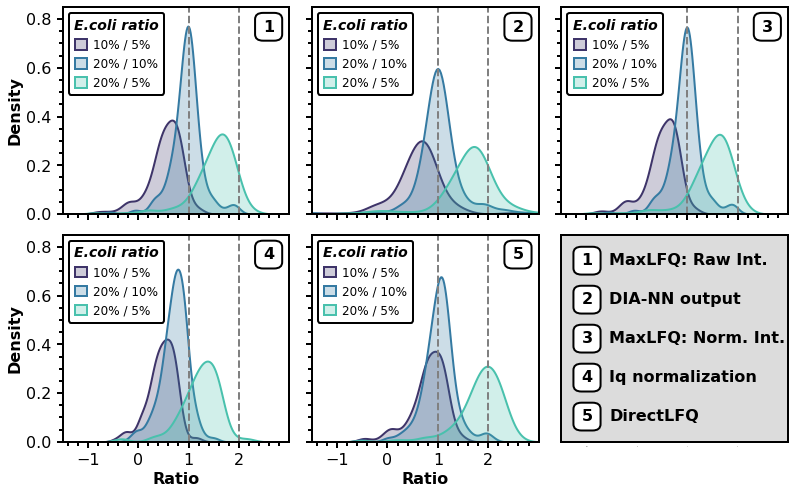

In [5]:
fig, ax = plt.subplots(2,3, figsize=(13,8), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
axs = fig.axes

for i in range(len(axs)-1):
    sns.kdeplot(data=ec_ratio_meltss[0][i], x='value', hue='variable', fill=True, lw=lw, palette='mako_r', ax=axs[i])
    
    axs[i].axvline(x=1, linestyle='dashed', color='grey', lw=lw)
    axs[i].axvline(x=2, linestyle='dashed', color='grey', lw=lw)
    
    axs[i].set_xlim([-1.5,3])
    axs[i].set_ylim([0, 0.85])
    
    for axis in ['bottom', 'top', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(2)
      
    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='major', direction='out', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    axs[i].tick_params(axis='both', which='minor', direction='out', pad=5, length=lw*2, width=lw)
    axs[i].set_xticks([-1,0,1,2])
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
    axs[i].text(x=2.48, y=0.75, s=str(i+1), fontsize=fontsize, weight='bold', bbox=props)
    
    legend = axs[i].legend(labels=['10% / 5%', '20% / 10%', '20% / 5%'], handlelength=1, handleheight=1,
                           labelspacing=0.5, handletextpad=0.5, fontsize=fontsize-4, framealpha=1, edgecolor='black',
                           title='E.coli ratio', title_fontproperties={'weight':'bold', 'size': fontsize-2, 'style':'italic'}, 
                           borderpad=0.45)
    legend.get_frame().set_linewidth(2)
    
    axs[5].text(x=-1.1, y=0.725-0.16*i, s=str(i+1), fontsize=fontsize, weight='bold', bbox=props)

for i in range(2):
    axs[i+3].set_xlabel('Ratio', fontsize=fontsize, weight='bold')

axs[0].set_ylabel('Density', fontsize=fontsize, weight='bold')
axs[3].set_ylabel('Density', fontsize=fontsize, weight='bold')

for axis in ['bottom', 'top', 'left', 'right']:
    axs[5].spines[axis].set_linewidth(2)
    
axs[5].set_xlabel('')
axs[5].tick_params(axis='both', which='major', length=0, labelsize=0)
axs[5].tick_params(axis='both', which='minor', length=0)
axs[5].set_facecolor('gainsboro')

for i, method in enumerate(['MaxLFQ: Raw Int.', 'DIA-NN output', 'MaxLFQ: Norm. Int.', 'Iq normalization', 'DirectLFQ']):
    axs[5].text(x=-0.55, y=0.725-0.16*i, s=method, fontsize=fontsize, weight='bold')
    
# plt.savefig('02_Figures/Protein_Quan_Acc_Normalisations.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_Quan_Acc_Normalisations.pdf', dpi=400, bbox_inches='tight')  

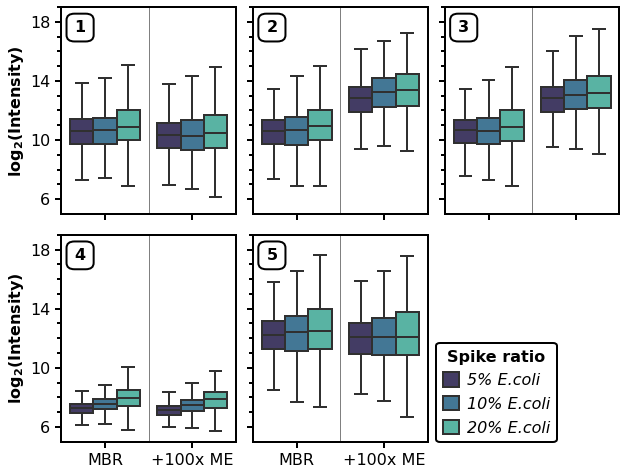

In [6]:
fig, ax = plt.subplots(2,3, figsize=(10,8), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1)  
axs = fig.axes
fig.delaxes(axs[5])

for i, (melt1, melt2) in enumerate(zip(ec_int_meltss[0], ec_int_meltss[1])):
    
    boxdata = pd.concat([melt1.assign(dataset='MBR'), melt2.assign(dataset='+100x ME')])
    
    sns.boxplot(data=boxdata, y='value', x='dataset', hue='variable', showfliers=False,
                palette='mako', ax=axs[i], linewidth=lw)
    
    axs[i].set_ylim([5, 19])
    axs[i].set_yticks([6,10,14,18])
    
    axs[i].axvline(x=0.5, linestyle='solid', color='grey', lw=1)
    
    for axis in ['bottom', 'top', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(2)
      
    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='major', direction='out', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    axs[i].tick_params(axis='y', which='minor', direction='out', pad=5, length=lw*2, width=lw)
    axs[i].tick_params(axis='x', which='minor', length=0)
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    
    axs[i].text(x=-0.35, y=17.3, s=str(i+1), fontsize=fontsize, weight='bold', bbox=props)
    
    axs[i].get_legend().remove()
    
axs[0].set_ylabel('log'+r'$\bf{_{2}}$' + '(Intensity)', fontsize=fontsize, weight='bold')
axs[3].set_ylabel('log'+r'$\bf{_{2}}$' + '(Intensity)', fontsize=fontsize, weight='bold')

handles = [axs[4].patches[0], axs[4].patches[2], axs[4].patches[4]]
legend = axs[4].legend(handles=handles, labels=['5% E.coli', '10% E.coli', '20% E.coli'],
                       handlelength=1, handleheight=1, labelspacing=0.5, handletextpad=0.5, 
                       framealpha=1, edgecolor='black', prop=dict(style='italic', size=fontsize),
                       title='Spike ratio', title_fontproperties={'weight':'bold', 'size': fontsize}, loc=(1.05,0))
legend.get_frame().set_linewidth(2)

# plt.savefig('02_Figures/Protein_Quan_Int_Normalisations.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_Quan_Int_Normalisations.pdf', dpi=400, bbox_inches='tight')

In [7]:
dlfq_reports = [pd.read_csv(path + folders[2] + 'filteredEcoli_joined_noME.report.tsv.protein_intensities.tsv', sep='\t'),
                pd.read_csv(path + folders[2] + 'filteredEcoli_joined_5.report.tsv.protein_intensities.tsv', sep='\t'),
                pd.read_csv(path + folders[2] + 'filteredEcoli_joined_10.report.tsv.protein_intensities.tsv', sep='\t'),
                pd.read_csv(path + folders[2] + 'filteredEcoli_joined_100.report.tsv.protein_intensities.tsv', sep='\t')]

for i, report in enumerate(dlfq_reports):

    quan_cols = [c for c in report.columns if 'ng' in c]
    dlfq_reports[i] = report[quan_cols + ['Protein.Names']].set_index('Protein.Names')
    dlfq_reports[i].columns = new_cols
    dlfq_reports[i] = dlfq_reports[i].replace(0, np.nan)

    dlfq_reports[i] = np.log2(dlfq_reports[i])


In [8]:
valid_values = 4

ec_ratios = []
hs_ratios = []
ec_melts = []
hs_melts = []
for i, report in enumerate(dlfq_reports):

    ec_frame = report[~report.index.str.contains('HUMAN')]
    hs_frame = report[~report.index.str.contains('ECOLI')]

    ec_dfs = []
    hs_dfs = []
    for spike in spikes:
        ec = ec_frame[spike].dropna(thresh=valid_values)
        hs = hs_frame[spike].dropna(thresh=valid_values)
        
        ec[spike + '_mean'] = ec.mean(axis=1)
        hs[spike + '_mean'] = hs.mean(axis=1)
        
        ec_dfs.append(ec)
        hs_dfs.append(hs)

    ec_f = reduce(lambda left, right: pd.merge(left, right, how='outer', left_index=True, right_index=True), ec_dfs)
    hs_f = reduce(lambda left, right: pd.merge(left, right, how='outer', left_index=True, right_index=True), hs_dfs)
    filtered = [ec_f, hs_f]
    
    for i, df in enumerate(filtered):
        df.loc[:, (spikes[2] + ' / ' + spikes[0])] = df[spikes[2] + '_mean'].sub(df[spikes[0] + '_mean'])
        df.loc[:, (spikes[2] + ' / ' + spikes[1])] = df[spikes[2] + '_mean'].sub(df[spikes[1] + '_mean'])
        df.loc[:, (spikes[1] + ' / ' + spikes[0])] = df[spikes[1] + '_mean'].sub(df[spikes[0] + '_mean'])

        ratios = [c for c in df.columns if '/' in c]
        filtered[i] = df[ratios]

    ec_ratios.append(filtered[0].dropna(how='all'))
    hs_ratios.append(filtered[1].dropna(how='all'))
    
    ec_melts.append(filtered[0].melt().dropna())
    hs_melts.append(filtered[1].melt().dropna())


In [9]:
names = ['MBR', '+5x ME', '+10x ME', '+100x ME']

for i in range(len(ec_melts)):
    ec_melts[i]['Experiment'] = names[i]
    hs_melts[i]['Experiment'] = names[i]
    
ec_melt = pd.concat(ec_melts)
hs_melt = pd.concat(hs_melts)

lib = {'HE20 / HE05': 2, 'HE20 / HE10': 1, 'HE10 / HE05': 1}

ec_melt['Deviation'] = ec_melt['value'].sub(ec_melt['variable'].map(lib))

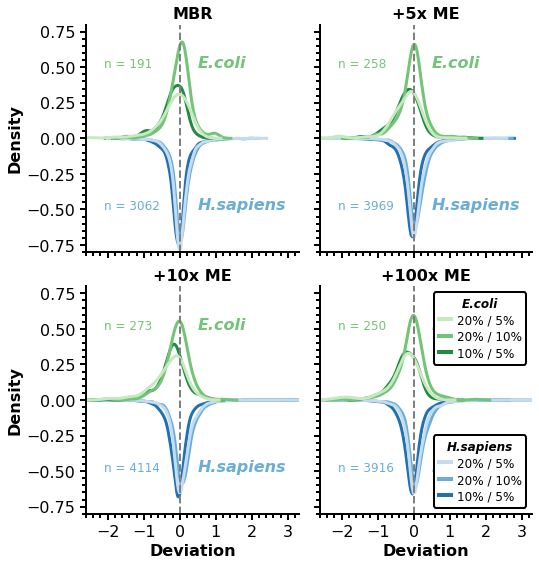

In [10]:
ec_colors = sns.color_palette('Greens',3)
hs_colors = sns.color_palette('Blues',3)

legend_labels = ['20% / 5%', '20% / 10%', '10% / 5%']

fig, ax = plt.subplots(2, 2, figsize=(8,9), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.15)
axs = fig.axes

for i in range(4):
    frame1 = ec_melt[ec_melt['Experiment'] == names[i]]
    frame2 = hs_melt[hs_melt['Experiment'] == names[i]]
    
    sns.kdeplot(data=frame2, x='value', hue='variable', lw=lw*1.5, palette=hs_colors, ax=axs[i])
    hs_lines = []
    for j in range(3):
        inverted = 1 - axs[i].lines[j].get_ydata() - 1
        axs[i].lines[j].set_ydata(inverted)
        
        line = Line2D([], [], color=hs_colors[j], label=legend_labels[j], linewidth=lw*2)
        hs_lines.append(line)
        
    sns.kdeplot(data=frame1, x='Deviation', hue='variable', lw=lw*1.5, palette=ec_colors, ax=axs[i])
    ec_lines = []
    for j in range(3):
        line = Line2D([], [], color=ec_colors[j], label=legend_labels[j], linewidth=lw*2)
        ec_lines.append(line)
         
    axs[i].axvline(x=0, linestyle='dashed', linewidth=lw, color='grey')
    
    axs[i].text(x=-2.1, y=0.5, s='n = ' + str(len(ec_ratios[i])), fontsize=fontsize-4, color=ec_colors[1])
    axs[i].text(x=-2.1, y=-0.5, s='n = ' + str(len(hs_ratios[i])), fontsize=fontsize-4, color=hs_colors[1])
    
    axs[i].text(x=0.5, y=0.5, s='E.coli', fontsize=fontsize, fontweight='bold', style='italic', color=ec_colors[1])
    axs[i].text(x=0.5, y=-0.5, s='H.sapiens', fontsize=fontsize, fontweight='bold', style='italic', color=hs_colors[1])
    
    axs[i].set_xlim(-2.6, 3.3)
    axs[i].set_ylim(-0.8, 0.8)
    
    for axis in ['top', 'right']:
        axs[i].spines[axis].set_visible(False)
    for axis in ['bottom', 'left']:
        axs[i].spines[axis].set_linewidth(lw)

    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='major', direction='out', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    axs[i].tick_params(axis='both', which='minor', direction='out', pad=5, length=lw*2, width=lw)
    
    axs[i].set_ylabel('Density', fontsize=fontsize, fontweight='bold')
    axs[i].set_xlabel('Deviation', fontsize=fontsize, fontweight='bold')
    axs[i].set_xticks([-2,-1,0,1,2,3])
    
    axs[i].set_title(names[i], fontsize=fontsize, fontweight='bold')
    axs[i].get_legend().remove()
    
legend1 = axs[3].legend(handles=ec_lines, fontsize=fontsize-4, loc=1, title='E.coli', labelspacing=0.3,
                        title_fontproperties=dict(weight='bold', size=fontsize-4, style='italic'),
                        handletextpad=0.5, handlelength=1, handleheight=1, edgecolor='black', framealpha=1)
legend1.get_frame().set_linewidth(2)
axs[3].add_artist(legend1)

legend2 = axs[3].legend(handles=hs_lines, fontsize=fontsize-4, loc=4, title='H.sapiens', labelspacing=0.3,
                        title_fontproperties=dict(weight='bold', size=fontsize-4, style='italic'),
                        handletextpad=0.5, handlelength=1, handleheight=1, edgecolor='black', framealpha=1)
legend2.get_frame().set_linewidth(2)

# plt.savefig('02_Figures/Protein_Quan_Acc_DIA-ME.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/Protein_Quan_Acc_DIA-ME.pdf', dpi=400, bbox_inches='tight')